# NBA Game Data — EDA (Robust Schema)

This version is tolerant to multiple schema styles (e.g., **HOME/VISITOR** vs **HOME/AWAY**, `*_home`/`*_away`, `GAME_DATE_EST`, etc.) and won't crash if some columns are missing. It also prints the exact column mapping it detected.


In [1]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import warnings, json
warnings.filterwarnings('ignore')
OUTDIR = Path('eda_outputs'); OUTDIR.mkdir(exist_ok=True)
print('Output dir:', OUTDIR.resolve())

Output dir: /content/eda_outputs


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_GAMES = Path('data/games.csv')
DATA_ODDS  = Path('data/odds.csv')  # optional
assert DATA_GAMES.exists(), 'Missing data/games.csv'

In [4]:
games_raw = pd.read_csv(DATA_GAMES)
print('games.csv shape:', games_raw.shape)
display(games_raw.head(3))

def pick(df, *cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

# Detect columns across common schemas
date_c = pick(games_raw, 'GAME_DATE', 'GAME_DATE_EST', 'game_date', 'date')
home_id_c = pick(games_raw, 'HOME_TEAM_ID', 'TEAM_ID_home', 'HOME_ID')
away_id_c = pick(games_raw, 'AWAY_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID_away', 'AWAY_ID')
home_abbr_c = pick(games_raw, 'HOME_TEAM_ABBREV', 'HOME_TEAM_ABBREVIATION', 'TEAM_ABBREVIATION_home', 'HOME', 'home_team')
away_abbr_c = pick(games_raw, 'AWAY_TEAM_ABBREV', 'VISITOR_TEAM_ABBREVIATION', 'TEAM_ABBREVIATION_away', 'AWAY', 'away_team')
home_pts_c = pick(games_raw, 'HOME_PTS', 'PTS_home', 'home_pts', 'HOME_SCORE')
away_pts_c = pick(games_raw, 'AWAY_PTS', 'PTS_away', 'away_pts', 'AWAY_SCORE')
win_flag_c = pick(games_raw, 'home_team_wins', 'HOME_TEAM_WINS', 'home_win')

df = games_raw.copy()
if date_c is None:
    raise ValueError('Could not detect a date column (e.g., GAME_DATE or GAME_DATE_EST).')
df['GAME_DATE'] = pd.to_datetime(df[date_c])
if home_id_c is not None: df['HOME_TEAM_ID'] = df[home_id_c]
if away_id_c is not None: df['AWAY_TEAM_ID'] = df[away_id_c]
if home_abbr_c is not None: df['HOME_TEAM_ABBREV'] = df[home_abbr_c]
if away_abbr_c is not None: df['AWAY_TEAM_ABBREV'] = df[away_abbr_c]
if home_pts_c is not None: df['HOME_PTS'] = df[home_pts_c]
if away_pts_c is not None: df['AWAY_PTS'] = df[away_pts_c]

if win_flag_c is not None:
    df['home_team_wins'] = df[win_flag_c].astype(int)
elif ('HOME_PTS' in df.columns) and ('AWAY_PTS' in df.columns):
    df['home_team_wins'] = (df['HOME_PTS'] > df['AWAY_PTS']).astype(int)
else:
    df['home_team_wins'] = np.nan

if 'GAME_ID' not in df.columns:
    left = df.get('HOME_TEAM_ABBREV', df.get('HOME_TEAM_ID', 0)).astype(str)
    right = df.get('AWAY_TEAM_ABBREV', df.get('AWAY_TEAM_ID', 0)).astype(str)
    df['GAME_ID'] = df['GAME_DATE'].dt.strftime('%Y%m%d') + '_' + left + '_' + right

# Print detected mapping
detected = {
    'GAME_DATE <-': date_c,
    'HOME_TEAM_ID <-': home_id_c,
    'AWAY_TEAM_ID <-': away_id_c,
    'HOME_TEAM_ABBREV <-': home_abbr_c,
    'AWAY_TEAM_ABBREV <-': away_abbr_c,
    'HOME_PTS <-': home_pts_c,
    'AWAY_PTS <-': away_pts_c,
    'home_team_wins <-': win_flag_c or 'derived from points' if ('HOME_PTS' in df.columns and 'AWAY_PTS' in df.columns) else 'N/A'
}
print('Detected mapping:')
for k,v in detected.items():
    print(f"  {k} {v}")

# Safe preview — only show columns that exist
preview_cols = [c for c in ['GAME_DATE','HOME_TEAM_ABBREV','AWAY_TEAM_ABBREV','HOME_PTS','AWAY_PTS','home_team_wins'] if c in df.columns]
display(df[preview_cols].head(5))

games.csv shape: (25796, 21)


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0


Detected mapping:
  GAME_DATE <- GAME_DATE_EST
  HOME_TEAM_ID <- HOME_TEAM_ID
  AWAY_TEAM_ID <- VISITOR_TEAM_ID
  HOME_TEAM_ABBREV <- None
  AWAY_TEAM_ABBREV <- None
  HOME_PTS <- PTS_home
  AWAY_PTS <- PTS_away
  home_team_wins <- HOME_TEAM_WINS


,GAME_DATE,HOME_PTS,AWAY_PTS,home_team_wins
0,2022-03-12,104.0,113.0,0
1,2022-03-12,101.0,91.0,1
2,2022-03-12,108.0,119.0,0
3,2022-03-12,122.0,109.0,1
4,2022-03-12,115.0,127.0,0


In [5]:
def season_from_date(ts):
    y = ts.year
    return y if ts.month >= 8 else y - 1
df['SEASON'] = df['GAME_DATE'].apply(season_from_date)
print('Date coverage:', df['GAME_DATE'].min(), '→', df['GAME_DATE'].max())
print('Seasons:', sorted(df['SEASON'].unique())[:5], '... total', df['SEASON'].nunique())

Date coverage: 2003-10-05 00:00:00 → 2022-03-12 00:00:00
Seasons: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007)] ... total 19


,SEASON,games
0,2003,1385
1,2004,1362
2,2005,1432
3,2006,1419
4,2007,1411
5,2008,1425
6,2009,1424
7,2010,1422
8,2011,1104
9,2012,1420


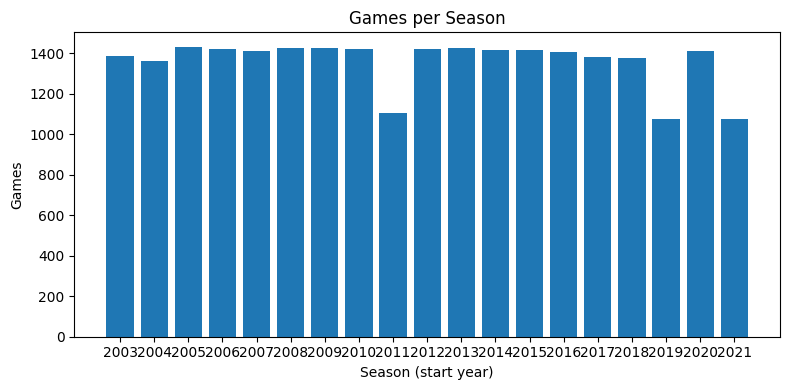

In [6]:
by_season = df.groupby('SEASON').size().rename('games').reset_index()
display(by_season)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(by_season['SEASON'].astype(str), by_season['games'])
plt.title('Games per Season')
plt.xlabel('Season (start year)')
plt.ylabel('Games')
plt.tight_layout(); plt.savefig(OUTDIR/'games_per_season.png', dpi=160); plt.show()

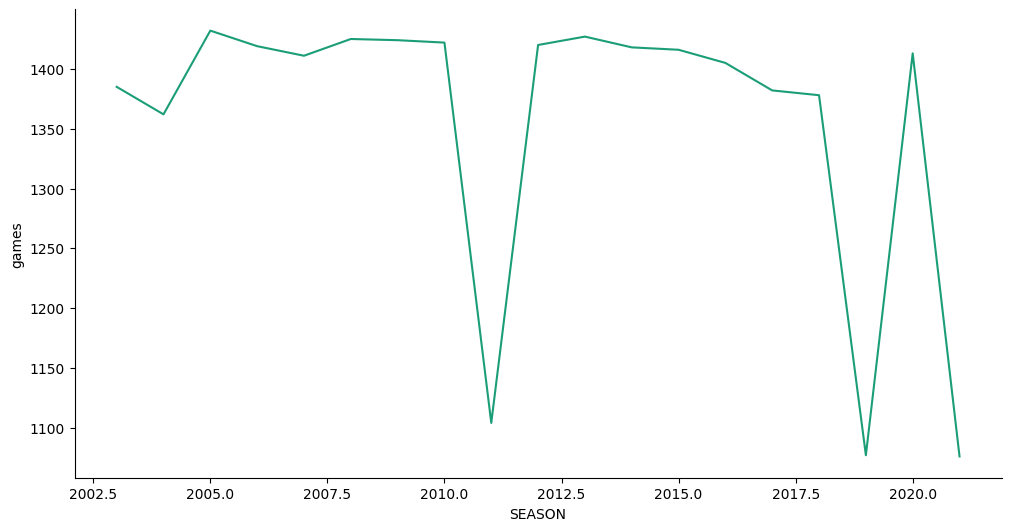

In [9]:
# @title SEASON vs games

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SEASON']
  ys = series['games']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = by_season.sort_values('SEASON', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SEASON')
_ = plt.ylabel('games')

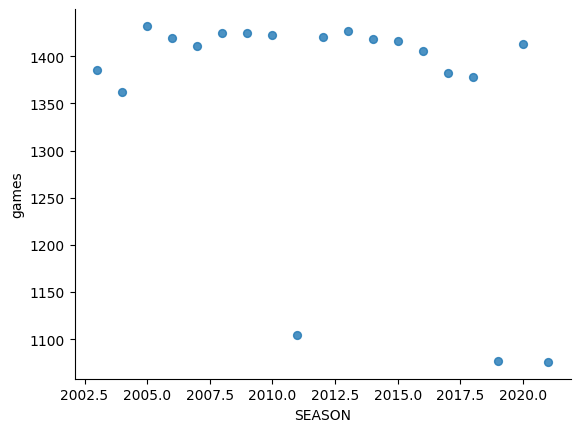

In [8]:
# @title SEASON vs games

from matplotlib import pyplot as plt
by_season.plot(kind='scatter', x='SEASON', y='games', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Overall home win rate: 0.587


,SEASON,home_win_rate
0,2003,0.577617
1,2004,0.604993
2,2005,0.604749
3,2006,0.591261
4,2007,0.610914
5,2008,0.601404
6,2009,0.601826
7,2010,0.612518
8,2011,0.594203
9,2012,0.614085


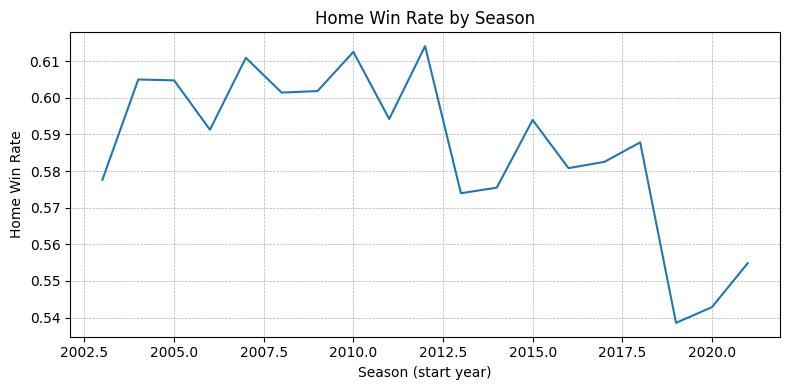

In [7]:
if 'home_team_wins' in df.columns:
    overall_hw = float(df['home_team_wins'].mean())
    print('Overall home win rate:', round(overall_hw,3))
    hw_by_season = df.groupby('SEASON')['home_team_wins'].mean().reset_index(name='home_win_rate')
    display(hw_by_season)
    plt.figure(figsize=(8,4))
    plt.plot(hw_by_season['SEASON'], hw_by_season['home_win_rate'])
    plt.title('Home Win Rate by Season')
    plt.xlabel('Season (start year)')
    plt.ylabel('Home Win Rate')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout(); plt.savefig(OUTDIR/'home_win_rate_by_season.png', dpi=160); plt.show()
else:
    print('home_team_wins not available — skipping home advantage plots.')

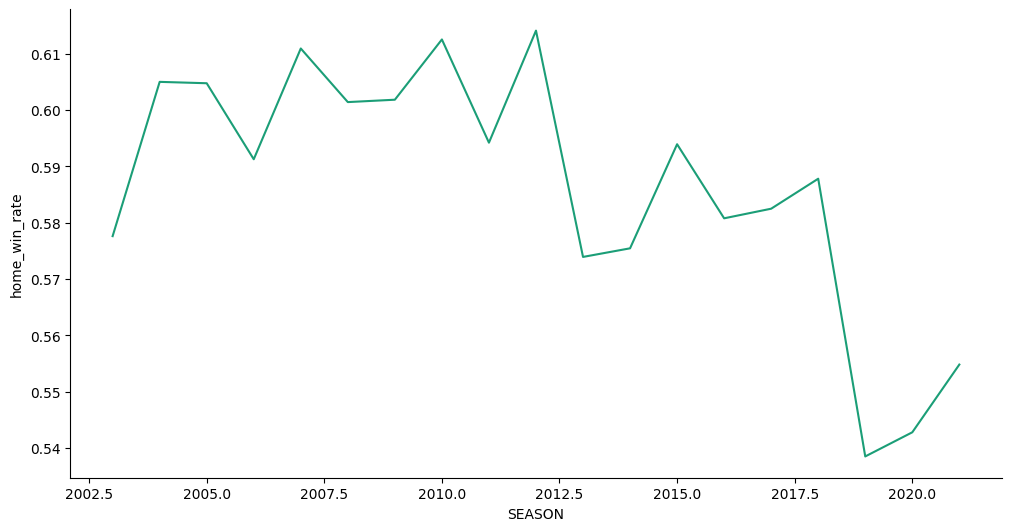

In [10]:
# @title SEASON vs home_win_rate

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SEASON']
  ys = series['home_win_rate']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hw_by_season.sort_values('SEASON', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SEASON')
_ = plt.ylabel('home_win_rate')